In [1]:
from six.moves import cPickle as pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
from torch import optim, cuda
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from PIL import Image

In [2]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


## 1. Load the cifar 10 dataset and preprocessing
The data is downloaded from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [3]:
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding="latin1")
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(root):
    test_datafile = os.path.join(root, "test_batch")
    meta_datafile = os.path.join(root, "batches.meta")
    
    xs = []
    ys = []
    for b in range(1,6):
        train_datafile = os.path.join(root, "data_batch_{0}".format(b))
        X, Y = load_CIFAR_batch(train_datafile)
        xs.append(X)
        ys.append(Y)
    X_train = np.concatenate(xs)
    Y_train = np.concatenate(ys)
    
    X_test, Y_test = load_CIFAR_batch(test_datafile)

    with open(meta_datafile, "rb") as f:
        # this file includes the label index to name mapping
        datadict = pickle.load(f, encoding="latin1")
        labels = np.array(datadict["label_names"])

    return X_train, Y_train, X_test, Y_test, labels

def get_cifar10_data():
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers.
    """
    # Load the raw CIFAR-100 data
    cifar10_dir = "./datasets/"
    X_train, Y_train, X_test, Y_test, _ = load_CIFAR10(cifar10_dir)

    X_train = X_train.astype("float")
    X_test = X_test.astype("float")

    # subtract the mean
    mean = np.mean(X_train, axis=0)
    X_train -= mean
    X_test -= mean

    Y_train = np.squeeze(Y_train)
    Y_test = np.squeeze(Y_test)

    print("X (training)   shape:", X_train.shape)
    print("Y (training)   shape:", Y_train.shape)
    print("X (test) shape:", X_test.shape)
    print("Y (test) shape:", Y_test.shape)

    return X_train, Y_train, X_test, Y_test

In [4]:
X_train, Y_train, X_test, Y_test = get_cifar10_data()

X (training)   shape: (50000, 3, 32, 32)
Y (training)   shape: (50000,)
X (test) shape: (10000, 3, 32, 32)
Y (test) shape: (10000,)


Convert the datasets to tensors with predefined batch size  

In [5]:
BATCH_SIZE = 16
data = {
    "train": TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).to(torch.long)),
    "test": TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).to(torch.long)),
    
}

dataloaders = {
    "train": DataLoader(data["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    "valid": DataLoader(data["test"], batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

## 2. Define a linear model

In [4]:
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_part = nn.Sequential(
            nn.Linear(32*32*3, 1024, bias=True),
            nn.ReLU(),
            nn.Linear(1024, 1024, bias=True),
            nn.ReLU(),
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(),
            nn.Linear(512, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 128, bias=True),
            nn.ReLU(),
            nn.Linear(128, 32, bias=True),
            nn.ReLU(),
            nn.Linear(32, num_classes, bias=True),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_part(x)
        return x

## 3. Train the network
The training code is adapted from HW4

In [7]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_best_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            
            # Tensors to gpu, both model parameters, data, and target need to be tensors.
            model.cuda()
            data = data.cuda()
            target = target.cuda()

            # Clear gradients
            optimizer.zero_grad()

            # Forward path
            output = model.forward(data)

            # Loss function 
            loss = criterion(output, target)

            # Backward path (backpropagation)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    model.cuda()
                    data = data.cuda()
                    target = target.cuda()

                    # Forward path
                    output = model.forward(data)

                    # Validation loss computation
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)


                # Calculate average losses and Calculate average accuracy
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    torch.save(model.state_dict(), save_file_name)

                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        # You can use model.load_state_dict()
                        model.load_state_dict(torch.load(save_file_name))

                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [5]:
num_classes = 10
model = MyModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [9]:
save_file_name = f'cifar_linear_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(model,
    criterion,
    optimizer,
    dataloaders['train'], 
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=500,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 52.36 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.6875 	Validation Loss: 1.5245
		Training Accuracy: 39.93%	 Validation Accuracy: 46.29%
Epoch: 1	100.00% complete. 45.96 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.4632 	Validation Loss: 1.4460
		Training Accuracy: 48.38%	 Validation Accuracy: 49.32%
Epoch: 2	100.00% complete. 65.34 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.3460 	Validation Loss: 1.4181
		Training Accuracy: 52.60%	 Validation Accuracy: 49.50%
Epoch: 3	100.00% complete. 92.78 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.2472 	Validation Loss: 1.4626
		Training Accuracy: 56.07%	 Validation Accuracy: 49.00%
Epoch: 4	100.00% complete. 84.66 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.1586 	Validation Loss: 1.3856
		Training Accuracy: 59.00%	 Validation Accuracy: 52.27%
Epoch: 5	100.00% complete. 70.23 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.0796 	Validation

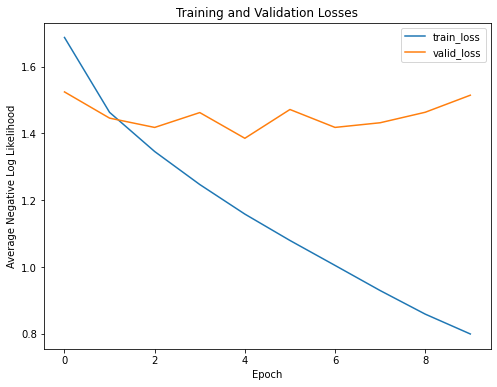

In [10]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

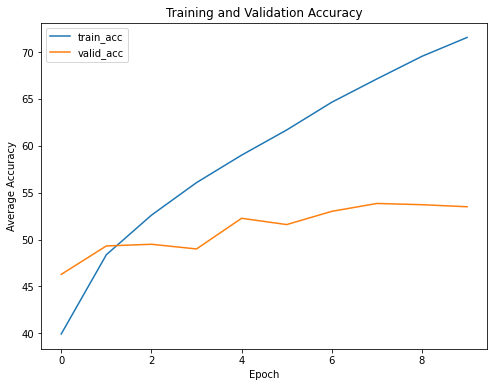

In [11]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

## 4. Visualize the feature importance using saliency map
In this section, I will use the saliency map to see what features the neural network is using to predict the classification. This helps us understand if the model is learning the correct features.

In [6]:
def get_cifar10_data_unmodified():
    # Load the raw CIFAR-100 data
    cifar10_dir = "./datasets/"
    X_train, Y_train, X_test, Y_test, labels = load_CIFAR10(cifar10_dir)

    X_train = X_train.astype("float")
    X_test = X_test.astype("float")

    # although we don't need to subtract the mean now, we record it for preprocessing the data to feed into the model
    x_mean = np.mean(X_train, axis=0)

    Y_train = np.squeeze(Y_train)
    Y_test = np.squeeze(Y_test)

    print("X (training)   shape:", X_train.shape)
    print("Y (training)   shape:", Y_train.shape)
    print("X (test) shape:", X_test.shape)
    print("Y (test) shape:", Y_test.shape)

    return X_train, Y_train, X_test, Y_test, labels, x_mean

In [7]:
def plot_saliency(labels, img_idx, true_label_idx, original_img, x_mean, model):
    # transform the image to torch.Tensor, subtract the mean
    sub_img = original_img - x_mean
    sub_img = np.reshape(sub_img, (1, sub_img.shape[0], sub_img.shape[1], sub_img.shape[2]))
    input = torch.from_numpy(sub_img).float().cuda()
    
    # we need the gradient with respect to the input
    input.requires_grad = True

    y_pred = model(input)

    score, indices = torch.max(y_pred, dim=1)
    # back propagate the score to get gradients
    score.backward()
    # find the maximum gradients
    max_grad, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    # normalize to [0,1]
    max_grad = (max_grad - max_grad.min()) / (max_grad.max() - max_grad.min())
    max_grad = max_grad.cpu().numpy()
    max_grad_constrained = np.where(max_grad >= 0.5, 1, 0)

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 4, 1)
    plt.title("img {0} label {1} \n predicted as {2}".format(img_idx, labels[true_label_idx], labels[indices.detach().cpu().numpy()[0]]))
    # the original image data is C*H*W, but for plotting, we need H*W*C
    arr = np.transpose(X_test[img_idx], (1, 2, 0))
    im = Image.fromarray(np.array(arr, dtype=np.uint8))
    plt.imshow(im)

    plt.subplot(1, 4, 2)
    # plot the saliency map
    plt.title("saliency map")
    plt.imshow(max_grad, cmap=plt.cm.hot)

    plt.subplot(1, 4, 3)
    # plot the constrained saliency map for better visualization
    plt.title("saliency map 2")
    plt.imshow(max_grad_constrained, cmap=plt.cm.hot)

    plt.subplot(1, 4, 4)
    plt.title("composed saliency + original image")
    max_grad_idx_y, max_grad_idx_x = np.where(max_grad >= 0.5)
    plt.scatter(max_grad_idx_x, max_grad_idx_y)
    plt.imshow(im)
    plt.show()

In [8]:
X_train, Y_train, X_test, Y_test, labels, x_mean = get_cifar10_data_unmodified()

X (training)   shape: (50000, 3, 32, 32)
Y (training)   shape: (50000,)
X (test) shape: (10000, 3, 32, 32)
Y (test) shape: (10000,)


Load and set the model to be in evaluation model  
Also ignore all the gradients with respect to weights

In [9]:
num_classes = 10
model = MyModel(num_classes)
model.load_state_dict(torch.load("cifar_linear_best_model.pt"))
model.optimizer = optimizer
model.cuda()
model.eval()
for param in model.parameters():
    param.requires_grad = False

Get a list of failure images in the test set

In [16]:
valid_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).to(torch.long))
valid_data = DataLoader(valid_data, batch_size=1, shuffle=False, num_workers=2)
idx = 0
failed_pics = []
for data, target in valid_data:
    # Tensors to gpu
    data = data.cuda()
    target = target.cuda()

    # Forward path
    output = model.forward(data)
    _, pred = torch.max(output, dim=1)
    pred = pred.detach().cpu().numpy()[0]
    if pred != Y_test[idx]:
        failed_pics.append(idx)
    
    idx += 1

print(len(failed_pics))

6743


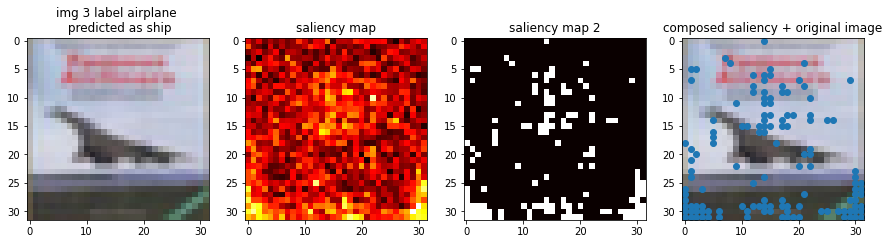

In [10]:
# failed_idx = failed_pics[0]
plot_saliency(labels, 3, Y_test[3], X_test[3], x_mean, model)

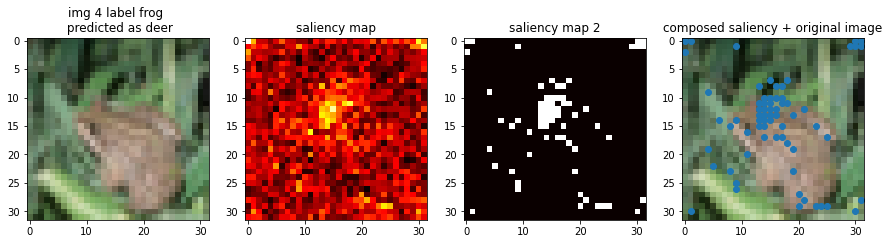

In [11]:
# failed_idx = failed_pics[1]
plot_saliency(labels, 4, Y_test[4], X_test[4], x_mean, model)

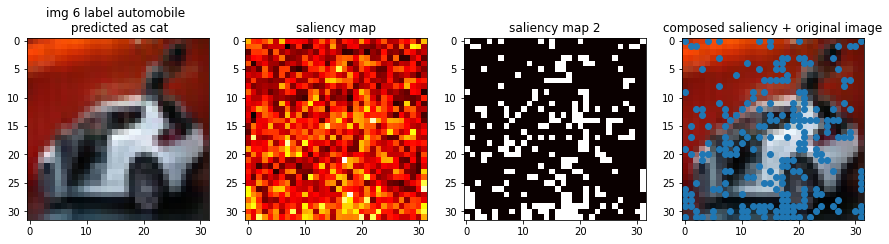

In [12]:
# failed_idx = failed_pics[3]
plot_saliency(labels, 6, Y_test[6], X_test[6], x_mean, model)